# Lasso Regression Model for Fertility Rate Prediction

This notebook develops a Lasso (L1-regularized) linear regression model to predict global fertility
rates using socioeconomic, demographic, and public-health indicators.

## Why Lasso?
Lasso applies an L1 penalty to model coefficients, shrinking weaker predictors to zero.
This makes it especially useful for:
- Feature selection and interpretability
- Reducing model complexity
- Handling multicollinearity between predictors
- Preventing overfitting in high-dimensional data

## Model Structure:
- Input: Tabular dataset of standardized fertility-related predictors
- Algorithm: L1-regularized linear regression (Lasso)
- Optimization: Cross-validated alpha (regularization strength)
- Output: Continuous predicted fertility rate
- Result: Identifies the most influential global factors affecting fertility levels

## 1. Imports & Configuration

In [112]:
# Imports and configuration
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

from IPython.display import display

# Set plotting style and random seed for reproducibility
sns.set(style="whitegrid")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1.1 Load Dataset

In [57]:
# Load cleaned dataset
df_model = pd.read_csv('../data/clean/lasso_model_data.csv')

# Print basic identifier stats
print("Dataset loaded successfully!")
print(f"\nDataset shape: {df_model.shape}")
print(f"Rows: {df_model.shape[0]:,}")
print(f"Columns: {df_model.shape[1]}")

# Check for missing values in each column
print("\nMissing values per column:")
print(df_model.isna().sum())

# List columns explicitly for reference
print("\nColumns in the dataset:")
print(df_model.columns.tolist())

Dataset loaded successfully!

Dataset shape: (13856, 10)
Rows: 13,856
Columns: 10

Missing values per column:
Unnamed: 0                                            0
Country Name                                          0
Country Code                                          0
Year                                                  0
Maternal mortality ratio (per 100,000 live births)    0
Fertility rate                                        0
Urban population over total population                0
Capitial GDP in USD                                   0
InfantMortality                                       0
LifeExpectancy                                        0
dtype: int64

Columns in the dataset:
['Unnamed: 0', 'Country Name', 'Country Code', 'Year', 'Maternal mortality ratio (per 100,000 live births)', 'Fertility rate', 'Urban population over total population', 'Capitial GDP in USD', 'InfantMortality', 'LifeExpectancy']


## 2. Preprocessing for Lasso Regression

We perform minimal but essential preprocessing:

- Drop identifier / non-predictive columns:
  - `Unnamed: 0`
  - `Country Name`
  - `Country Code`


In [58]:
# Drop identifier columns
# These are indexing / label columns, not true predictors.
drop_cols = ["Unnamed: 0", "Country Name", "Country Code"]

print("\nDropping non-predictive columns:", drop_cols)
df_model = df_model.drop(columns=drop_cols)

print("\nRemaining columns for modeling:")
print(df_model.columns.tolist())


Dropping non-predictive columns: ['Unnamed: 0', 'Country Name', 'Country Code']

Remaining columns for modeling:
['Year', 'Maternal mortality ratio (per 100,000 live births)', 'Fertility rate', 'Urban population over total population', 'Capitial GDP in USD', 'InfantMortality', 'LifeExpectancy']


## 3. Define Features and Target

We use:

- **Target (`y`)**: `Fertility rate`
- **Features (`X`)**: all other remaining columns.

In [59]:
# Define target and feature matrix
target_col = "Fertility rate"

X = df_model.drop(columns=[target_col])
y = df_model[target_col]

print("\nFeature columns (X):")
print(X.columns.tolist())
print("\nTarget column (y):", target_col)



Feature columns (X):
['Year', 'Maternal mortality ratio (per 100,000 live births)', 'Urban population over total population', 'Capitial GDP in USD', 'InfantMortality', 'LifeExpectancy']

Target column (y): Fertility rate


## 4. Train/Test Split

We split the data into:

- 80% training
- 20% testing

In [60]:
# Split into 20% testing
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=test_size,
    random_state=RANDOM_STATE
)

print("\nTrain/test split completed.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Train/test split completed.
X_train shape: (11084, 6)
X_test shape: (2772, 6)
y_train shape: (11084,)
y_test shape: (2772,)


## 5. Correlation of Features with Fertility Rate (Train Set)

This gives a rough idea of how each predictor is linearly associated with fertility,
before regularization and scaling.

In [61]:
train_corr_df = pd.concat([X_train, y_train], axis=1)
corr_with_target = train_corr_df.corr()[target_col].sort_values(ascending=False)

print("\nCorrelation of each feature with Fertility rate (train set):")
corr_df = corr_with_target.to_frame(name="Correlation")
display(corr_df)


Correlation of each feature with Fertility rate (train set):


,Correlation
Fertility rate,1.000000
InfantMortality,0.781739
"Maternal mortality ratio (per 100,000 live births)",0.646571
Capitial GDP in USD,-0.414842
Year,-0.475970
Urban population over total population,-0.609138
LifeExpectancy,-0.807467


## 6. Lasso Pipeline and Hyperparameter Grid

Lasso is very sensitive to feature scales, so we use a `Pipeline`:

1. `StandardScaler` – standardizes each feature to mean 0 and variance 1.
2. `Lasso` – linear regression with L1 penalty, which can shrink some coefficients
   exactly to zero (feature selection).

We then create a grid of `alpha` values (regularization strengths) on a log scale.

In [62]:
from sklearn.utils.validation import check_is_fitted

# Define the Lasso pipeline
lasso_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("lasso", Lasso(max_iter=5000, random_state=RANDOM_STATE))
    ]
)

# Define a grid of alpha values (log-spaced)
alpha_values = np.logspace(-4, 2, 40)  # from 1e-4 to 1e2

print("\nAlpha grid for Lasso (log-spaced):")
print(alpha_values)


Alpha grid for Lasso (log-spaced):
[1.00000000e-04 1.42510267e-04 2.03091762e-04 2.89426612e-04
 4.12462638e-04 5.87801607e-04 8.37677640e-04 1.19377664e-03
 1.70125428e-03 2.42446202e-03 3.45510729e-03 4.92388263e-03
 7.01703829e-03 1.00000000e-02 1.42510267e-02 2.03091762e-02
 2.89426612e-02 4.12462638e-02 5.87801607e-02 8.37677640e-02
 1.19377664e-01 1.70125428e-01 2.42446202e-01 3.45510729e-01
 4.92388263e-01 7.01703829e-01 1.00000000e+00 1.42510267e+00
 2.03091762e+00 2.89426612e+00 4.12462638e+00 5.87801607e+00
 8.37677640e+00 1.19377664e+01 1.70125428e+01 2.42446202e+01
 3.45510729e+01 4.92388263e+01 7.01703829e+01 1.00000000e+02]


## 7. Hyperparameter Tuning with Cross-Validation

We use `GridSearchCV` to find the best `alpha` that minimizes the **mean squared error** (MSE)
through 5-fold cross-validation on the training data.

In [63]:
from sklearn.model_selection import KFold

# Cross-validation setup (5-fold)
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Parameter grid for GridSearchCV
param_grid = {"lasso__alpha": alpha_values}

# Grid search using negative MSE as scoring (higher is better)
grid_search = GridSearchCV(
    estimator=lasso_pipeline,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

print("\nStarting GridSearchCV for Lasso...")
grid_search.fit(X_train, y_train)

print("\nGrid search completed.")
print("Best params:", grid_search.best_params_)
print("Best CV score (negative MSE):", grid_search.best_score_)

best_lasso_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_["lasso__alpha"]
print("Best alpha selected:", best_alpha)


Starting GridSearchCV for Lasso...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Grid search completed.
Best params: {'lasso__alpha': np.float64(0.00701703828670383)}
Best CV score (negative MSE): -1.2520008165376995
Best alpha selected: 0.00701703828670383


## 8. Model Evaluation on Train and Test Sets

We evaluate the best model using:

- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- R² score

We compare performance on:

- Training data (to see fit quality)
- Test data (to assess generalization)

In [64]:
def evaluate_regression(y_true, y_pred, dataset_name=""):
    """Utility function to print regression metrics for a given dataset."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n[{dataset_name}] Performance:")
    print(f"  MSE : {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE : {mae:.4f}")
    print(f"  R²  : {r2:.4f}")

# Predictions on train and test sets
y_train_pred = best_lasso_model.predict(X_train)
y_test_pred = best_lasso_model.predict(X_test)

# Evaluate
evaluate_regression(y_train, y_train_pred, dataset_name="Train")
evaluate_regression(y_test,  y_test_pred,  dataset_name="Test")



[Train] Performance:
  MSE : 1.2495
  RMSE: 1.1178
  MAE : 0.8676
  R²  : 0.6819

[Test] Performance:
  MSE : 1.2535
  RMSE: 1.1196
  MAE : 0.8693
  R²  : 0.6947


## 9.  Coefficient Analysis (Feature Importance)

Lasso coefficients show how each standardized feature contributes to predicting fertility.
Coefficients shrunk to **zero** indicate features that Lasso dropped as unimportant at
the selected `alpha`.

We sort features by the absolute magnitude of their coefficients.

In [66]:
# Extract the fitted Lasso step from the pipeline
lasso_step = best_lasso_model.named_steps["lasso"]

# Ensure the model is fitted
check_is_fitted(lasso_step)

coefficients = lasso_step.coef_

coef_df = pd.DataFrame(
    {
        "Feature": X.columns,
        "Coefficient": coefficients
    }
).sort_values(by="Coefficient", key=lambda s: s.abs(), ascending=False)

print("\nLasso coefficients (sorted by absolute magnitude):")
display(coef_df)


Lasso coefficients (sorted by absolute magnitude):


,Feature,Coefficient
5,LifeExpectancy,-0.873747
4,InfantMortality,0.471382
2,Urban population over total population,-0.262349
0,Year,-0.199513
3,Capitial GDP in USD,-0.038988
1,"Maternal mortality ratio (per 100,000 live bir...",0.000000


## 10. Regularization Effect on Model Coefficients

To understand how Lasso performs feature selection, we examine how coefficient
values change as the regularization parameter α increases. Higher α values apply
stronger penalties, shrinking more coefficients toward zero and reducing the
number of active predictors.

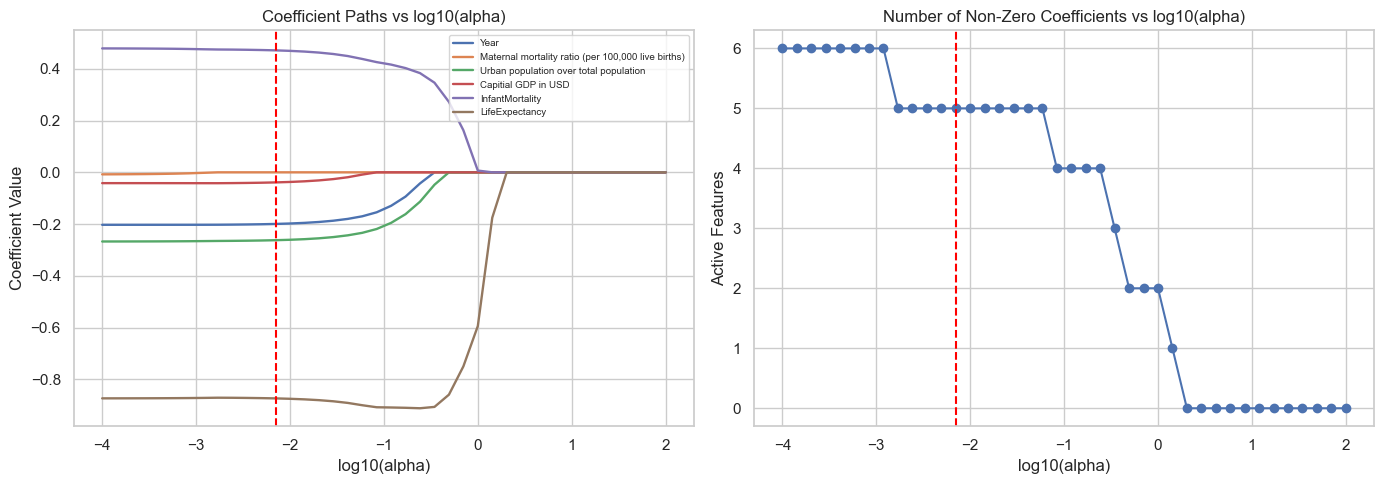

In [85]:
# Manually explore coefficient paths across alphas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

coef_paths = []
nonzero_counts = []

for a in alpha_values:
    model = Lasso(alpha=a, max_iter=5000, random_state=RANDOM_STATE)
    model.fit(X_train_scaled, y_train)
    coef_paths.append(model.coef_)
    nonzero_counts.append(np.sum(model.coef_ != 0))

coef_paths = np.array(coef_paths)

# Subplot 1 coefficient shrinkage
log_alphas = np.log10(alpha_values)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, f in enumerate(X.columns):
    axes[0].plot(log_alphas, coef_paths[:, i], label=f, linewidth=1.7)

axes[0].axvline(np.log10(best_alpha), color="red", linestyle="--")
axes[0].set_title("Coefficient Paths vs log10(alpha)")
axes[0].set_xlabel("log10(alpha)")
axes[0].set_ylabel("Coefficient Value")
axes[0].legend(loc="best", fontsize=7)

# Subplot 2  model sparsity
axes[1].plot(log_alphas, nonzero_counts, marker="o")
axes[1].axvline(np.log10(best_alpha), color="red", linestyle="--")
axes[1].set_title("Number of Non-Zero Coefficients vs log10(alpha)")
axes[1].set_xlabel("log10(alpha)")
axes[1].set_ylabel("Active Features")

plt.tight_layout()
plt.show()

##  11. Prediction and Residual Diagnostics

We evaluate the model’s predictive performance and error behavior using three complementary visual checks:

1. **Predicted vs Actual Fertility** — assesses how well model outputs align with true observations.
2. **Residuals vs Predicted** — reveals potential bias, heteroscedasticity, or unexplained structure.
3. **Residual Distribution** — examines error symmetry, spread, and the presence of heavy tails or outliers.


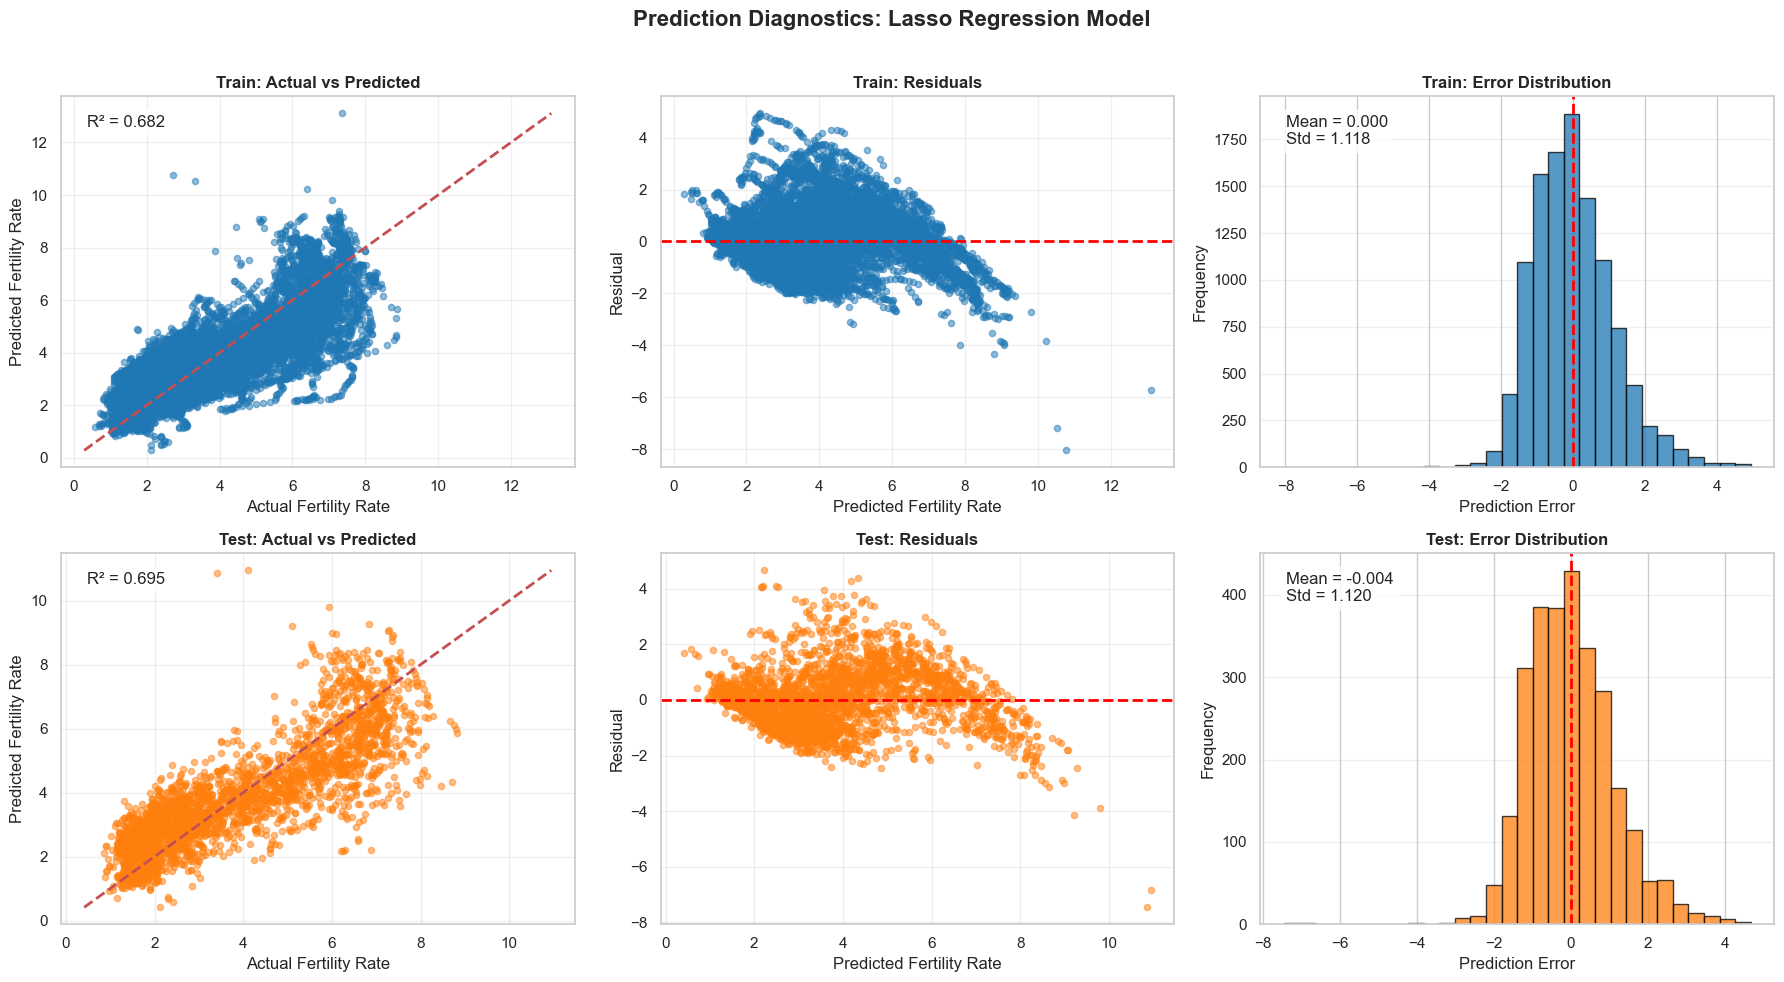

In [86]:
from sklearn.metrics import r2_score

# Dataset grouping for looping
prediction_sets = [
    ("Train", y_train, y_train_pred, "tab:blue"),
    ("Test",  y_test,  y_test_pred,  "tab:orange"),
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for row, (name, y_true, y_pred, color) in enumerate(prediction_sets):

    residuals = y_true - y_pred

    # Actual vs Predicted Scatter
    ax1 = axes[row, 0]
    ax1.scatter(y_true, y_pred, alpha=0.5, s=20, color=color)

    # 45-degree reference line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

    ax1.set_title(f"{name}: Actual vs Predicted", fontweight="bold")
    ax1.set_xlabel("Actual Fertility Rate")
    ax1.set_ylabel("Predicted Fertility Rate")
    ax1.grid(alpha=0.3)

    # R² annotation
    r2 = r2_score(y_true, y_pred)
    ax1.text(
        0.05, 0.95, f"R² = {r2:.3f}",
        transform=ax1.transAxes,
        va="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )

    # Residuals vs Predicted Scatter
    ax2 = axes[row, 1]
    ax2.scatter(y_pred, residuals, alpha=0.5, s=20, color=color)
    ax2.axhline(0, color="red", linestyle="--", linewidth=2)

    ax2.set_title(f"{name}: Residuals", fontweight="bold")
    ax2.set_xlabel("Predicted Fertility Rate")
    ax2.set_ylabel("Residual")
    ax2.grid(alpha=0.3)

    # Error Distribution Histogram
    ax3 = axes[row, 2]
    ax3.hist(residuals, bins=30, color=color, alpha=0.75, edgecolor="black")
    ax3.axvline(0, color="red", linestyle="--", linewidth=2)

    ax3.set_title(f"{name}: Error Distribution", fontweight="bold")
    ax3.set_xlabel("Prediction Error")
    ax3.set_ylabel("Frequency")
    ax3.grid(axis="y", alpha=0.3)

    # Mean & Std annotation
    ax3.text(
        0.05, 0.95,
        f"Mean = {residuals.mean():.3f}\nStd = {residuals.std():.3f}",
        transform=ax3.transAxes,
        va="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )

plt.suptitle("Prediction Diagnostics: Lasso Regression Model", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## 12. Lasso Coefficient Magnitudes

We visualize the Lasso coefficients as a horizontal bar chart, sorted by absolute magnitude,
to make it easy to see which predictors have the largest effect on fertility.

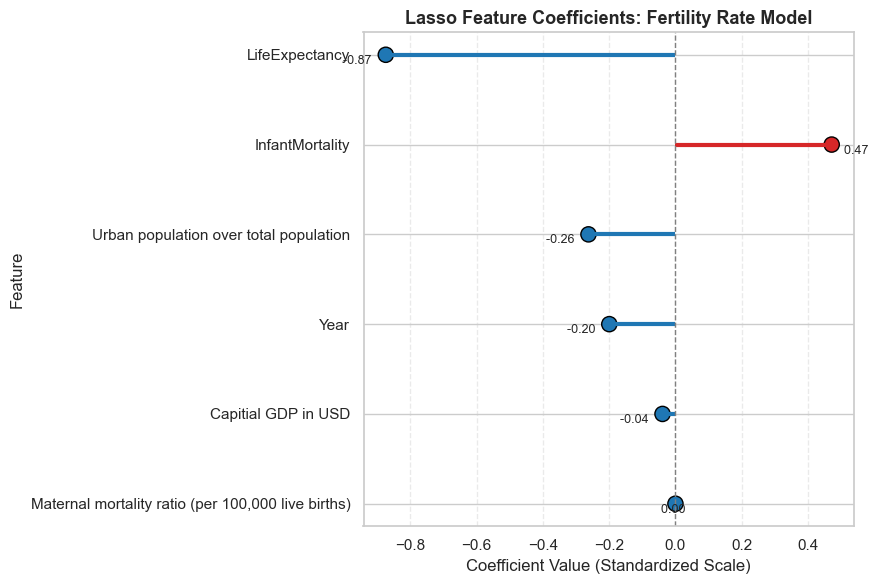

In [99]:
# Sort features by absolute coefficient size for clearer interpretation
coef_sorted = coef_df.sort_values(by="Coefficient", key=abs, ascending=True)

fig, ax = plt.subplots(figsize=(9, 6))

# Assign colors based on whether coefficients are positive or negative
colors = coef_sorted["Coefficient"].apply(lambda c: "tab:red" if c > 0 else "tab:blue")

# Plot horizontal stems (lollipop plot)
ax.hlines(
    y=coef_sorted["Feature"],
    xmin=0,
    xmax=coef_sorted["Coefficient"],
    color=colors,
    linewidth=3
)

# Add circular markers at the end of each stem
ax.scatter(
    coef_sorted["Coefficient"],
    coef_sorted["Feature"],
    color=colors,
    s=120,
    edgecolor="black"
)

# Draw vertical zero-reference line for clarity
ax.axvline(0, color="gray", linestyle="--", linewidth=1)

# Add coefficient value labels next to markers
for coeff, feature in zip(coef_sorted["Coefficient"], coef_sorted["Feature"]):
    ax.text(
        coeff + (0.08 * np.sign(coeff)),
        feature,
        f"{coeff:.2f} ",
        ha="center",
        va="top",
        fontsize=9
    )

# Titles and labels
ax.set_title("Lasso Feature Coefficients: Fertility Rate Model", fontsize=13, fontweight="bold")
ax.set_xlabel("Coefficient Value (Standardized Scale)")
ax.set_ylabel("Feature")

# Light grid for readability
ax.grid(axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

## 14. Final Model Summary

This section consolidates key configuration details, cross-validation results, predictive
performance metrics, and interpretability outcomes from the Lasso regression model.

In [110]:
# Helper functions for metrics
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

# Try to get number of folds if cv is a splitter, else fall back
try:
    n_folds = cv.get_n_splits()
except AttributeError:
    n_folds = cv if isinstance(cv, int) else "N/A"

# Training metrics
train_rmse = rmse(y_train, y_train_pred)
train_mae  = mae(y_train, y_train_pred)
train_r2   = r2(y_train, y_train_pred)

# Test metrics
test_rmse = rmse(y_test, y_test_pred)
test_mae  = mae(y_test, y_test_pred)
test_r2   = r2(y_test, y_test_pred)

# Summary Statements
print("="*80)
print("LASSO REGRESSION MODEL: FINAL SUMMARY")
print("="*80)

print("\nModel Configuration:")
print(f"  - Input features: {X_train.shape[1]}")
print(f"  - Regularization type: L1 (Lasso)")
print(f"  - Best alpha (λ) selected via CV: {best_alpha:.5f}")
print(f"  - Feature scaling: StandardScaler()")
print(f"  - Cross-validation folds: {n_folds}")

print("\nTraining & Optimization:")
print("  - Hyperparameter search space: logspace(-4, 2, 40)")
print(f"  - Best CV score (neg. MSE): {grid_search.best_score_:.5f}")
print("  - Objective: Minimize prediction error and enforce sparsity in coefficients")

print("\nFinal Performance:")

print("\n  Training Set:")
print(f"    RMSE: {train_rmse:.4f}")
print(f"    MAE:  {train_mae:.4f}")
print(f"    R²:   {train_r2:.4f}")

print("\n  Test Set:")
print(f"    RMSE: {test_rmse:.4f}")
print(f"    MAE:  {test_mae:.4f}")
print(f"    R²:   {test_r2:.4f}")

print("\nModel Interpretability:")
print(f"  - Total features considered: {len(X.columns)}")
print(f"  - Non-zero coefficients after regularization: {(coefficients  != 0).sum()}")
print(f"  - Features eliminated (set to zero): {(coefficients  == 0).sum()}")


LASSO REGRESSION MODEL: FINAL SUMMARY

Model Configuration:
  - Input features: 6
  - Regularization type: L1 (Lasso)
  - Best alpha (λ) selected via CV: 0.00702
  - Feature scaling: StandardScaler()
  - Cross-validation folds: 5

Training & Optimization:
  - Hyperparameter search space: logspace(-4, 2, 40)
  - Best CV score (neg. MSE): -1.25200
  - Objective: Minimize prediction error and enforce sparsity in coefficients

Final Performance:

  Training Set:
    RMSE: 1.1178
    MAE:  0.8676
    R²:   0.6819

  Test Set:
    RMSE: 1.1196
    MAE:  0.8693
    R²:   0.6947

Model Interpretability:
  - Total features considered: 6
  - Non-zero coefficients after regularization: 5
  - Features eliminated (set to zero): 1


## 15. Saving Lasso Model Outputs

To maintain consistency with the project structure and previously trained models,
the essential results from the Lasso regression—performance metrics and feature
coefficients.

Saved artifacts include:

- **lasso_metrics.json**: train/test RMSE, MAE, R², and model configuration
- **lasso_coefficients.csv**: standardized feature coefficients retained after L1 regularization


In [111]:
import os, json

# Directory
models_dir = "../models"

# Compute metrics
lasso_metrics = {
    "train": {
        "rmse": train_rmse,
        "mae":  train_mae,
        "r2":  train_r2
    },
    "test": {
        "rmse": test_rmse,
        "mae":  test_mae,
        "r2":   test_r2
    },
    "model_config": {
        "regularization": "L1 (Lasso)",
        "best_alpha": float(best_alpha),
        "num_input_features": int(X_train.shape[1]),
        "non_zero_coefficients": int((coefficients != 0).sum()),
        "zeroed_coefficients": int((coefficients == 0).sum())
    }
}

# Save metrics JSON
with open(os.path.join(models_dir, "lasso_metrics.json"), "w") as f:
    json.dump(lasso_metrics, f, indent=2)

# Save coefficient table
coef_df.to_csv(os.path.join(models_dir, "lasso_coefficients.csv"), index=False)

print("\nLasso model outputs saved:")
print(f"  - {models_dir}/lasso_metrics.json")
print(f"  - {models_dir}/lasso_coefficients.csv")



Lasso model outputs saved:
  - ../models/lasso_metrics.json
  - ../models/lasso_coefficients.csv
